### BERT Baseline 
[Training - BERT + Original labels](#1)  
[Training - BERT + Original labels + Personality (Benchmark)](#2)            
[Training - BERT + Relabeled data](#3)       
[Training - BERT + Relabeled + Personality](#4)      

<u>[Testing results](#5)</u>  
[BERT + Original labels](#6)  
[BERT + Original labels + Personality (Benchmark)](#7)            
[BERT + Relabeled data](#8)       
[BERT + Relabeled + Personality](#9)     
[BERT + Relabeled data + NLI](#10)       
[BERT + Relabeled + Personality + NLI](#11)       

In [1]:
import random
import numpy as np
import torch

# Set the seed value
seed_val = 42

# Python random
random.seed(seed_val)

# NumPy random
np.random.seed(seed_val)

# PyTorch random
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [2]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
from nltk.tokenize import TweetTokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('../dataset/relabeled_2000_samples_2.csv', encoding='utf-8-sig')

data

,Column1,text,ori_class,cleaned_text,true_class,openness,conscientiousness,extraversion,agreeableness,neuroticism
0,79033,Here are some jokes that don't have a punchlin...,non-suicide,Here are some jokes that don't have a punchlin...,non-suicide,0.862079,0.632528,0.299561,0.650520,0.004304
1,257115,I'll begin to blog on here before I end it on ...,suicide,I'll begin to blog on here before I end it on ...,suicide,0.561344,0.527004,0.222416,0.461801,0.022128
2,102858,"Just saw two friends vape, Do I snitch? So I l...",non-suicide,"Just saw two friends vape, Do I snitch? So I l...",non-suicide,0.726340,0.389685,0.347877,0.707561,0.022913
3,188810,Hey lads! Can I get some help from y'all? So.....,non-suicide,Hey lads! Can I get some help from y'all? So.....,non-suicide,0.753932,0.489636,0.230587,0.776817,0.031480
4,88124,Why do parents always bring up their “stories”...,non-suicide,"Why do parents always bring up their ""stories""...",non-suicide,0.802898,0.768912,0.275205,0.437977,0.032501
...,...,...,...,...,...,...,...,...,...,...
1995,272846,ContemplationI have everything I need to do It...,suicide,Contemplation. I have everything I need to do ...,suicide,0.747140,0.331684,0.412662,0.536295,0.939585
1996,49620,"I don't want to get better, I want to get wors...",suicide,"I don't want to get better, I want to get wors...",suicide,0.437285,0.340145,0.125675,0.653872,0.946523
1997,291094,My only friend died and I want to go with him....,suicide,My only friend died and I want to go with him....,suicide,0.395193,0.474021,0.074487,0.620530,0.958698
1998,138491,I fantasize about dying all the timeI think th...,suicide,I fantasize about dying all the time. I think ...,suicide,0.604205,0.529648,0.226070,0.512029,0.966551


#### 1
- Original labels (2000 samples)
- textual features only

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc


texts = data['cleaned_text']
labels = data['ori_class'].map({'suicide': 1, 'non-suicide': 0})
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long)  # ensure integer labels

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.3,      
    attention_probs_dropout_prob=0.3  
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',config=config)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(4):

    # train loop
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print('BERT Results:')
print(classification_report(val_labels, val_preds, digits=4))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
  Train Loss: 0.5298
  Val Loss:   0.3464
  Val Acc:    0.8700
------------------------------
Epoch 2
  Train Loss: 0.3327
  Val Loss:   0.2561
  Val Acc:    0.8900
------------------------------
Epoch 3
  Train Loss: 0.2342
  Val Loss:   0.2567
  Val Acc:    0.9000
------------------------------
Epoch 4
  Train Loss: 0.1899
  Val Loss:   0.2448
  Val Acc:    0.9025
------------------------------
BERT Results:
              precision    recall  f1-score   support

           0     0.9474    0.8438    0.8926       192
           1     0.8690    0.9567    0.9108       208

    accuracy                         0.9025       400
   macro avg     0.9082    0.9002    0.9017       400
weighted avg     0.9066    0.9025    0.9020       400



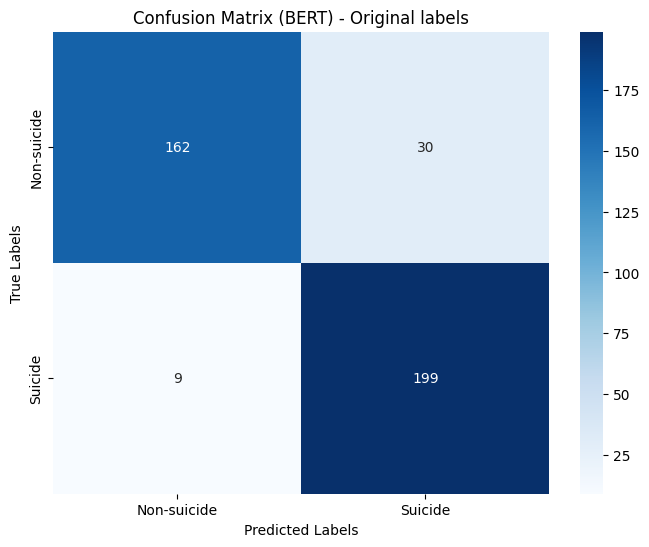

In [5]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT) - Original labels')
plt.show()


In [6]:
# Save the model
output_dir = "../saved_models/bert_raw"

#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  # view first 10 misclassified samples

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

C:\Users\PC\AppData\Local\Temp\ipykernel_14396\4199793669.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_14396\4199793669.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Number of misclassified samples: 39
                                                 text  true_label  pred_label  \
11  Why do people make me feel disregarded and uni...           0           1   
30  WHY ME Every time I send a message. Always in ...           0           1   
34  I think I should be back in the mental hospita...           0           1   
41  My life right now I literally just woke up fro...           0           1   
42  I got offered to go to Harvard. I'm stressed a...           0           1   
49  anyone want a free steam account?i have a stea...           1           0   
53  I really want to see my friend again. I met on...           0           1   
55  I miss affection. To the few people who see th...           0           1   
56  I'm happy. A few years ago, I was extremely de...           0           1   
58  15yo &amp Depression Hey guys i'm not english ...           0           1   

   true_label_name pred_label_name  
11     non-suicide         suicide 

### 2 
- Benchmark
- Original labels (2000 samples)
- Textual features + Personality

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc

# === Load data including personality features ===
texts = data['cleaned_text'].tolist()
labels = data['ori_class'].map({'suicide': 1, 'non-suicide': 0})
personality_features = data[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long) 

# Dataset with text tokens + personality features
class BertWithPersonalityDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, personality_feats, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.personality_feats = personality_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.input_ids[idx],
                self.attention_masks[idx],
                self.personality_feats[idx],
                self.labels[idx])
    
dataset = BertWithPersonalityDataset(input_ids, attention_masks, personality_features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

# ===== Custom model combining BERT + Personality Features =====
class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits


# ===== Config =====
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = BertWithPersonality.from_pretrained("bert-base-uncased", config=config)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# ===== Training Loop =====
for epoch in range(4):
    # Training
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        model.zero_grad()
        logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)

        loss = criterion(logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_val_loss = 0
    val_labels, val_preds, val_probs = [], [], []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)
            loss = criterion(logits, b_labels)
            total_val_loss += loss.item()

            label_ids = b_labels.to('cpu').numpy()

            # Probabilities for ROC-AUC
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            val_probs.extend(probs)

            predictions = np.argmax(logits.cpu().numpy(), axis=1)
            val_labels.extend(label_ids)
            val_preds.extend(predictions)

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print("BERT Results:")
print(classification_report(val_labels, val_preds, digits=4))


Some weights of BertWithPersonality were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
  Train Loss: 0.5390
  Val Loss:   0.3669
  Val Acc:    0.8700
------------------------------
Epoch 2
  Train Loss: 0.3116
  Val Loss:   0.2535
  Val Acc:    0.9150
------------------------------
Epoch 3
  Train Loss: 0.2443
  Val Loss:   0.3162
  Val Acc:    0.8650
------------------------------
Epoch 4
  Train Loss: 0.2087
  Val Loss:   0.2185
  Val Acc:    0.9300
------------------------------
BERT Results:
              precision    recall  f1-score   support

           0     0.9349    0.9029    0.9186       175
           1     0.9264    0.9511    0.9386       225

    accuracy                         0.9300       400
   macro avg     0.9307    0.9270    0.9286       400
weighted avg     0.9301    0.9300    0.9299       400



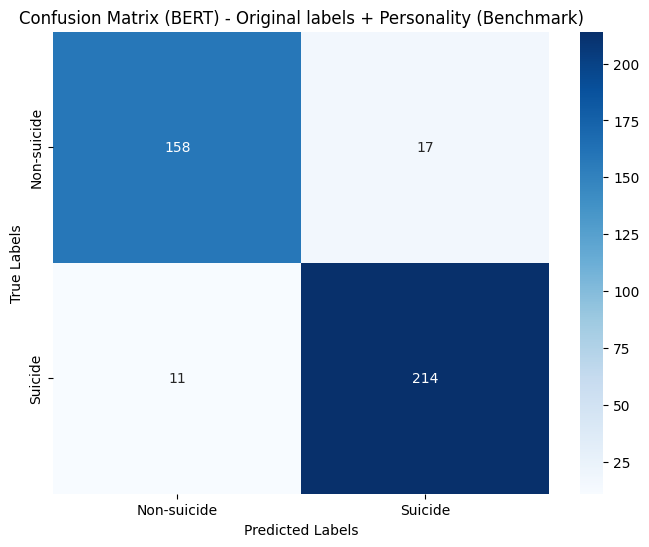

In [8]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT) - Original labels + Personality (Benchmark)')
plt.show()


In [9]:
# Save the model
output_dir = "../saved_models/bert_benchmark"

#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  # view first 10 misclassified samples

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

Number of misclassified samples: 28
                                                  text  true_label  \
14   Too Ugly For Love. There are ugly people, and ...           1   
17   My life right now I literally just woke up fro...           0   
29   Fresh meat You wake up in unknown place your h...           1   
41   Thank you all. I posted here earlier tonight, ...           1   
49   Different then the rest...to much sorry everyt...           1   
71   Just found out today how my parents really see...           1   
87   15yo &amp Depression Hey guys i'm not english ...           0   
100  Does anyone else feel this way? Idk what's wro...           0   
113  So I had to have my colon removed... Warning: ...           0   
115  Give me a valid reason Give me a valid reason ...           0   

     pred_label true_label_name pred_label_name  
14            0         suicide     non-suicide  
17            1     non-suicide         suicide  
29            0         suicide     non-sui

C:\Users\PC\AppData\Local\Temp\ipykernel_14396\3680327494.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_14396\3680327494.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Model state dict and tokenizer saved to ../saved_models/bert_benchmark


#### 3
- relabeled 2000 samples
- textual features only

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc


texts = data['cleaned_text']
labels = data['true_class'].map({'suicide': 1, 'non-suicide': 0})
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long)  # ensure integer labels

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.3,      
    attention_probs_dropout_prob=0.3  
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',config=config)


optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(4):

    # train loop
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print('BERT Results:')
print(classification_report(val_labels, val_preds, digits=4))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
  Train Loss: 0.4436
  Val Loss:   0.3326
  Val Acc:    0.8650
------------------------------
Epoch 2
  Train Loss: 0.2715
  Val Loss:   0.2269
  Val Acc:    0.9275
------------------------------
Epoch 3
  Train Loss: 0.1961
  Val Loss:   0.2066
  Val Acc:    0.9275
------------------------------
Epoch 4
  Train Loss: 0.1677
  Val Loss:   0.1961
  Val Acc:    0.9350
------------------------------
BERT Results:
              precision    recall  f1-score   support

           0     0.9418    0.9223    0.9319       193
           1     0.9289    0.9469    0.9378       207

    accuracy                         0.9350       400
   macro avg     0.9354    0.9346    0.9349       400
weighted avg     0.9351    0.9350    0.9350       400



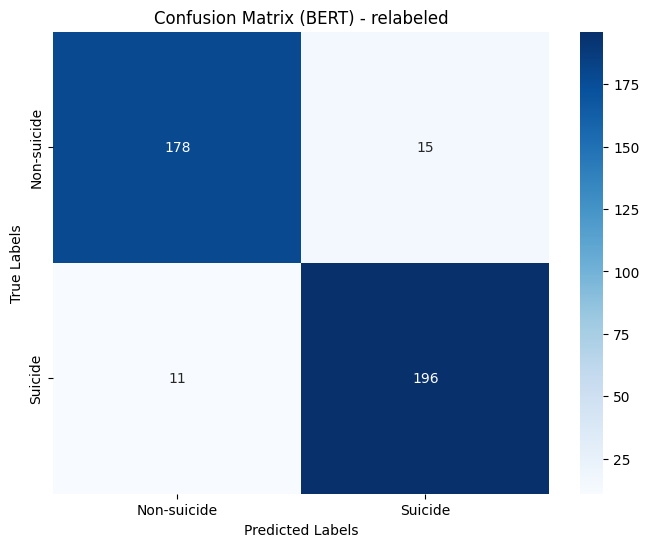

In [7]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT) - relabeled')
plt.show()


In [8]:
#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  

# Save the model
output_dir = "../saved_models/bert_relabeled"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

Number of misclassified samples: 26
                                                  text  true_label  \
4    i don't even think I'm going to make it to spr...           0   
45   I'm anxious about moving to Florida because I ...           0   
53   I don't want to live in my house anymore I'm 1...           0   
55   It's been two years since I almost ended my li...           0   
66   How painful is it if you slice your jugular ve...           1   
73   I'm tired of things getting better only to get...           1   
88   another painful year... ( sorry for bad spelli...           0   
107  Dear M,You're a good friend. I know it can be ...           1   
126  Count Down To Death Date: 2I had a dream last ...           1   
142  I just feel empty..... I just feel like sh*t. ...           0   

     pred_label true_label_name pred_label_name  
4             1     non-suicide         suicide  
45            1     non-suicide         suicide  
53            1     non-suicide         sui

C:\Users\PC\AppData\Local\Temp\ipykernel_7028\922119654.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_7028\922119654.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Model state dict and tokenizer saved to ../saved_models/bert_relabeled


#### 4
- relabeled 2000 samples
- textual features + personality

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc

# === Load data including personality features ===
texts = data['cleaned_text'].tolist()
labels = data['true_class'].map({'suicide': 1, 'non-suicide': 0})
personality_features = data[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long) 

# Dataset with text tokens + personality features
class BertWithPersonalityDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, personality_feats, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.personality_feats = personality_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.input_ids[idx],
                self.attention_masks[idx],
                self.personality_feats[idx],
                self.labels[idx])
    
dataset = BertWithPersonalityDataset(input_ids, attention_masks, personality_features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

# ===== Custom model combining BERT + Personality Features =====
class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits


# ===== Config =====
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = BertWithPersonality.from_pretrained("bert-base-uncased", config=config)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ===== Training Loop =====
for epoch in range(4):
    # Training
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        model.zero_grad()
        logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)

        loss = criterion(logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_val_loss = 0
    val_labels, val_preds, val_probs = [], [], []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)
            loss = criterion(logits, b_labels)
            total_val_loss += loss.item()

            label_ids = b_labels.to('cpu').numpy()

            # Probabilities for ROC-AUC
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            val_probs.extend(probs)

            predictions = np.argmax(logits.cpu().numpy(), axis=1)
            val_labels.extend(label_ids)
            val_preds.extend(predictions)

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f" Train Loss: {avg_train_loss:.4f}")
    print(f" Val Loss: {avg_val_loss:.4f}")
    print(f" Val Acc: {val_accuracy:.4f}")
    print("-" * 30)

print("BERT Results:")
print(classification_report(val_labels, val_preds, digits=4))


Some weights of BertWithPersonality were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
 Train Loss: 0.5360
 Val Loss: 0.3564
 Val Acc: 0.8775
------------------------------
Epoch 2
 Train Loss: 0.3379
 Val Loss: 0.2420
 Val Acc: 0.9200
------------------------------
Epoch 3
 Train Loss: 0.2710
 Val Loss: 0.2215
 Val Acc: 0.9200
------------------------------
Epoch 4
 Train Loss: 0.2109
 Val Loss: 0.2214
 Val Acc: 0.9150
------------------------------
BERT Results:
              precision    recall  f1-score   support

           0     0.9781    0.8565    0.9133       209
           1     0.8618    0.9791    0.9167       191

    accuracy                         0.9150       400
   macro avg     0.9199    0.9178    0.9150       400
weighted avg     0.9226    0.9150    0.9149       400



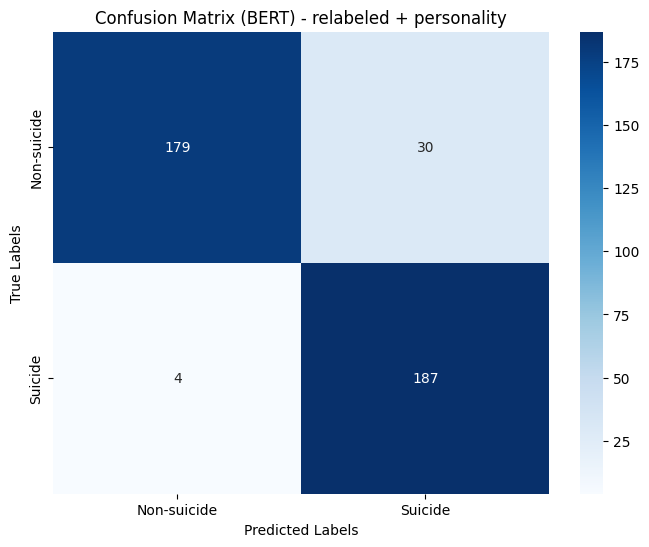

In [5]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT) - relabeled + personality')
plt.show()


In [6]:
#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  # view first 10 misclassified samples

# Save the model
output_dir = "../saved_models/bert_personality"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

C:\Users\PC\AppData\Local\Temp\ipykernel_28240\3355317618.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_28240\3355317618.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Number of misclassified samples: 34
                                                 text  true_label  pred_label  \
11  Why do people make me feel disregarded and uni...           0           1   
34  I think I should be back in the mental hospita...           0           1   
41  My life right now I literally just woke up fro...           0           1   
53  I really want to see my friend again. I met on...           0           1   
54  For all those considering suicide, here's a po...           0           1   
56  I'm happy. A few years ago, I was extremely de...           0           1   
58  15yo &amp Depression Hey guys i'm not english ...           0           1   
66  Are Sleeping Pills good for a 15 year old? Hel...           0           1   
71  Quick update. While reflecting upon my initial...           0           1   
78  Please check out this video i made I made this...           0           1   

   true_label_name pred_label_name  
11     non-suicide         suicide 


- relabeled 2000 samples
- textual features + personality + sentiment

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc

# === Load  data including personality features ===
texts = data['cleaned_text'].tolist()
labels = data['class'].map({'suicide': 1, 'non-suicide': 0})
personality_features = data[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32)

# === Add sentiment features ===
sentiment_features = data[['Negative', 'Neutral', 'Positive']].values
sentiment_features = torch.tensor(sentiment_features, dtype=torch.float32)

# Merge personality + sentiment features
aux_features = torch.cat((personality_features, sentiment_features), dim=1)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long) 

class BertWithAuxFeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, aux_feats, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.aux_feats = aux_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.input_ids[idx],
                self.attention_masks[idx],
                self.aux_feats[idx],
                self.labels[idx])
    
dataset = BertWithAuxFeaturesDataset(input_ids, attention_masks, aux_features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

# === Update model to reflect new aux feature size ===
class BertWithAuxFeatures(BertPreTrainedModel):
    def __init__(self, config, aux_dim):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        self.aux_layer = torch.nn.Linear(aux_dim, config.hidden_size)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
    
    def forward(self, input_ids, attention_mask, aux_feats):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # CLS token
        pooled_output = pooled_output + self.aux_layer(aux_feats)
        logits = self.classifier(pooled_output)
        return logits

config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2  
)

model = BertWithAuxFeatures(config, aux_dim=8)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(3):

    # train loop
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_aux, b_labels = batch
        model.zero_grad()
        logits = model(b_input_ids, attention_mask=b_input_mask, aux_feats=b_aux)
        loss = criterion(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_aux, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, aux_feats=b_aux)
        
        logits = outputs  
        loss = criterion(logits, b_labels)
        total_val_loss += loss.item()

        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits.cpu().numpy(), axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print('BERT Results:')
print(classification_report(val_labels, val_preds, digits=4))



KeyError: 'class'

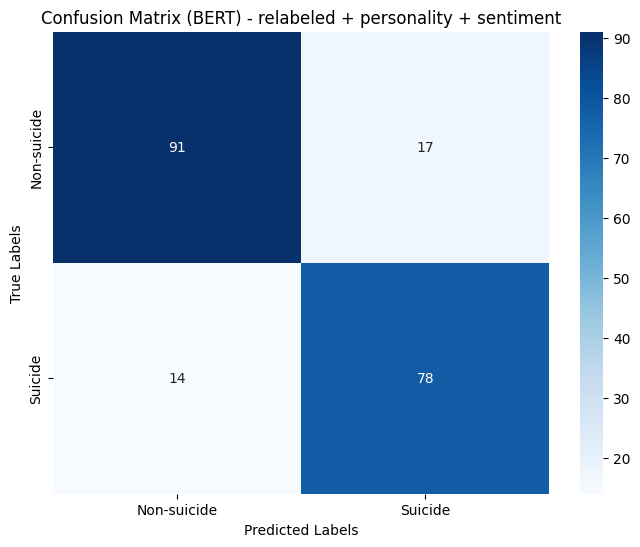

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT) - relabeled + personality + sentiment')
plt.show()

In [ ]:
# Save the entire model and tokenizer
output_dir = "../saved_models/bert_personality_sentiment"

torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model state dict and tokenizer saved to {output_dir}")


Model state dict and tokenizer saved to ../saved_models/bert_personality_sentiment


### 5
### Testing results

#### 6

In [10]:
# BERT + Original Labels
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')

# Map string labels to integers
label_map = {"non-suicide": 0, "suicide": 1}
true_labels_int = df['true_class'].map(label_map).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load BERT suicide classifier =====
model_dir = "../saved_models/bert_raw"
bert_model = BertForSequenceClassification.from_pretrained(model_dir)
bert_model.to(device).eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_dir)

# ===== Parameters =====
batch_size = 16  # adjust based on GPU memory
final_predictions = []

# ===== Batching for BERT inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    
    # BERT tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    # BERT predictions
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    final_predictions.extend(batch_preds)
    
    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels_int, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels_int, final_predictions, target_names=["Non-suicide", "Suicide"], zero_division=0))


Confusion Matrix:
[[418  82]
 [ 18 482]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.96      0.84      0.89       500
     Suicide       0.85      0.96      0.91       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



#### 7

In [11]:
# BERT + Original Labels + Personality Evaluation 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].map({'non-suicide':0, 'suicide':1}).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features =====
personality_features = df[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = BertTokenizer.from_pretrained('../saved_models/bert_benchmark')

class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained BERT + Personality model =====
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
bert_personality_model = BertWithPersonality.from_pretrained('../saved_models/bert_benchmark', config=config)
bert_personality_model.to(device).eval()

# ===== Parameters =====
batch_size = 16
final_predictions = []

# ===== Batching for BERT + Personality inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    batch_personality = personality_features[i:i+batch_size]

    # BERT tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # BERT + Personality predictions
    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        final_predictions.extend(batch_preds)

    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Non-suicide","Suicide"], zero_division=0))


Confusion Matrix:
[[422  78]
 [ 19 481]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.96      0.84      0.90       500
     Suicide       0.86      0.96      0.91       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



#### 8

In [12]:
# BERT + Relabeled Data Evaluation
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')

# Map string labels to integers
label_map = {"non-suicide": 0, "suicide": 1}
true_labels_int = df['true_class'].map(label_map).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load BERT suicide classifier =====
model_dir = "../saved_models/bert_relabeled"
bert_model = BertForSequenceClassification.from_pretrained(model_dir)
bert_model.to(device).eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_dir)

# ===== Parameters =====
batch_size = 16  # adjust based on GPU memory
final_predictions = []

# ===== Batching for BERT inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    
    # BERT tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    # BERT predictions
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    final_predictions.extend(batch_preds)
    
    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels_int, final_predictions)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels_int, final_predictions, target_names=["Non-suicide", "Suicide"], zero_division=0))


Confusion Matrix:
[[457  43]
 [ 36 464]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.93      0.91      0.92       500
     Suicide       0.92      0.93      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



#### 9 

In [14]:
# BERT + Relabeled Data + Personality Evaluation 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].map({'non-suicide':0, 'suicide':1}).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features =====
personality_features = df[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = BertTokenizer.from_pretrained('../saved_models/bert_personality')

class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits
# ===== Load pretrained BERT + Personality model =====
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
bert_personality_model = BertWithPersonality.from_pretrained('../saved_models/bert_personality', config=config)
bert_personality_model.to(device).eval()

# ===== Parameters =====
batch_size = 16
final_predictions = []

# ===== Batching for BERT + Personality inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    batch_personality = personality_features[i:i+batch_size]

    # BERT tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # BERT + Personality predictions
    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        final_predictions.extend(batch_preds)



    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Non-suicide","Suicide"], zero_division=0))

# ===== Save Misclassified Data =====
# Add ground truth numeric labels back to DataFrame for comparison
df['True_Label'] = ["non-suicide" if t==0 else "suicide" for t in true_labels]

# Filter misclassified samples
misclassified_df = df[df['True_Label'] != df['Predicted_Label']]

# Save to CSV
misclassified_df.to_csv("../misclassified_samples_2.csv", index=False, encoding="utf-8-sig")

print(f"Misclassified samples saved: {len(misclassified_df)}")

Confusion Matrix:
[[442  58]
 [ 18 482]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.96      0.88      0.92       500
     Suicide       0.89      0.96      0.93       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000

Misclassified samples saved: 76


#### 10

In [46]:
# BERT + Relabeled + NLI Evaluation 
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].values  

label_map = {"non-suicide": 0, "suicide": 1}
true_labels_int = df['true_class'].map(label_map).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load BERT suicide classifier =====
model_dir = "../saved_models/bert_relabeled"
bert_model = BertForSequenceClassification.from_pretrained(model_dir)
bert_model.to(device).eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_dir)

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses to detect supportive/awareness posts =====

negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.62):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(
            post,
            hypo,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  # [entail, neutral, contradict]
            entail_prob = probs[0].item()  # entailment
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    
    # If the max negative entailment is high, the post is likely non-suicidal
    return max_neg_entail_prob >= threshold

# ===== Parameters =====
batch_size = 16  # adjust based on GPU memory
final_predictions = []

# ===== Batching for BERT inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    
    # BERT tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    # BERT predictions
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    # Apply NLI negative filtering
    for text, pred in zip(batch_texts, batch_preds):
        if pred == 1:  # initially predicted as suicide
            is_negative = nli_negative_filter(text, threshold=0.62)
            final_predictions.append(0 if is_negative else 1)
        else:
            final_predictions.append(pred)

    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====

df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels_int, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels_int, final_predictions, target_names=["Non-suicide", "Suicide"], zero_division=0))



Confusion Matrix:
[[460  40]
 [ 43 457]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.91      0.92      0.92       500
     Suicide       0.92      0.91      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [22]:
# ===== Save output to CSV =====
output_df = df.copy()
output_df['Predicted_Label_Int'] = final_predictions

# Optionally, also save entailment probabilities for each post
# If you want, you can store the max entailment probability during NLI check:
# You would need to modify nli_check to return it for every post in a list

output_csv_path = "../dataset/bert_nli_predictions_2.csv"
output_df.to_csv(output_csv_path, index=False)
print(f"\nPredictions saved to {output_csv_path}")

# ===== Identify false negatives =====
false_negatives = df[(true_labels_int == 1) & (np.array(final_predictions) == 0)]

# ===== Save false negatives to CSV =====
fn_csv_path = "../dataset/false_negatives_2.csv"
false_negatives.to_csv(fn_csv_path, index=False)
print(f"False negative samples saved to {fn_csv_path}")

# ===== Identify false negatives =====
false_negatives = df[(true_labels_int == 0) & (np.array(final_predictions) == 1)]

# ===== Save false negatives to CSV =====
fn_csv_path = "../dataset/false_positive_2.csv"
false_negatives.to_csv(fn_csv_path, index=False)
print(f"False positive samples saved to {fn_csv_path}")


Predictions saved to ../dataset/bert_nli_predictions_2.csv
False negative samples saved to ../dataset/false_negatives_2.csv
False positive samples saved to ../dataset/false_positive_2.csv


#### 11

In [43]:
#BERT + Relabeled + Personality + NLI Evaluation 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AutoTokenizer, AutoModelForSequenceClassification

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].map({'non-suicide':0, 'suicide':1}).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features =====
personality_features = df[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = BertTokenizer.from_pretrained('../saved_models/bert_personality')

class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained BERT + Personality model =====
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
bert_personality_model = BertWithPersonality.from_pretrained('../saved_models/bert_personality', config=config)
bert_personality_model.to(device).eval()

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses for NLI filtering =====
negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.5):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(post, hypo, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  
            entail_prob = probs[0].item()  # entailment probability
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    return max_neg_entail_prob >= threshold

# ===== Parameters =====
batch_size = 16
final_predictions = []

# ===== Batching for BERT + Personality inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    batch_personality = personality_features[i:i+batch_size]

    # BERT tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # BERT + Personality predictions
    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

    # Apply NLI negative filtering
    for text, pred in zip(batch_texts, batch_preds):
        if pred == 1:  # initially predicted as suicide
            is_negative = nli_negative_filter(text, threshold=0.62)
            final_predictions.append(0 if is_negative else 1)
        else:
            final_predictions.append(pred)

    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Non-suicide","Suicide"], zero_division=0))


# ===== Save Misclassified Data =====
# Add ground truth numeric labels back to DataFrame for comparison
df['True_Label'] = ["non-suicide" if t==0 else "suicide" for t in true_labels]

# Filter misclassified samples
misclassified_df = df[df['True_Label'] != df['Predicted_Label']]

# Save to CSV
misclassified_df.to_csv("../misclassified_samples.csv", index=False, encoding="utf-8-sig")

print(f"Misclassified samples saved: {len(misclassified_df)}")

Confusion Matrix:
[[447  53]
 [ 25 475]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.95      0.89      0.92       500
     Suicide       0.90      0.95      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Misclassified samples saved: 78


Performance dataset size: 1000
FP test dataset size: 89
Testing thresholds for dual optimization (performance + FP reduction)...
Testing threshold: 0.60
  Performance - F1: 0.9198, FP: 52
  FP Test - FPR: 0.3258, FP: 29
Testing threshold: 0.62
  Performance - F1: 0.9241, FP: 53
  FP Test - FPR: 0.3483, FP: 31
Testing threshold: 0.64
  Performance - F1: 0.9283, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.65
  Performance - F1: 0.9293, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.66
  Performance - F1: 0.9293, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.68
  Performance - F1: 0.9284, FP: 54
  FP Test - FPR: 0.4270, FP: 38
Testing threshold: 0.70
  Performance - F1: 0.9277, FP: 56
  FP Test - FPR: 0.4382, FP: 39

MULTI-OBJECTIVE THRESHOLD OPTIMIZATION RESULTS
   threshold  combined_score  f1_score     fpr  fp_count  performance_fp
0       0.60          0.8706    0.9198  0.3258        29              52
1       0.62          0.8696    0.9241  

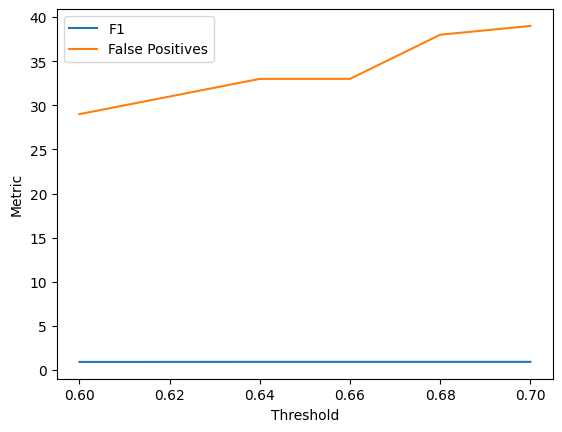

In [ ]:
# BERT + Relabeled + Personality + NLI Evaluation with Dual Optimization
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AutoTokenizer, AutoModelForSequenceClassification

# ===== Load both datasets =====
# Performance test dataset
df_performance = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels_perf = df_performance['true_class'].map({'non-suicide':0, 'suicide':1}).values

# False positive test dataset
df_fp = pd.read_csv('../dataset/false_positive_test_set_with_personality.csv')  
true_labels_fp = [0] * len(df_fp)  # All should be non-suicide

print(f"Performance dataset size: {len(df_performance)}")
print(f"FP test dataset size: {len(df_fp)}")

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features for both datasets =====
personality_features_perf = df_performance[["extraversion", "agreeableness", "neuroticism"]].values
personality_features_perf = torch.tensor(personality_features_perf, dtype=torch.float32).to(device)

personality_features_fp = df_fp[["extraversion", "agreeableness", "neuroticism"]].values
personality_features_fp = torch.tensor(personality_features_fp, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = BertTokenizer.from_pretrained('../saved_models/bert_personality')

class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained BERT + Personality model =====
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
bert_personality_model = BertWithPersonality.from_pretrained('../saved_models/bert_personality', config=config)
bert_personality_model.to(device).eval()

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses for NLI filtering =====
negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.65):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(post, hypo, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  # [entail, neutral, contradict]
            entail_prob = probs[0].item()  # entailment probability
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    return max_neg_entail_prob >= threshold

# ===== Function to evaluate dataset with specific threshold =====
def evaluate_dataset(df, personality_features, true_labels, threshold, dataset_name="Dataset"):
    final_predictions = []
    batch_size = 16
    
    for i in range(0, len(df), batch_size):
        batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
        batch_personality = personality_features[i:i+batch_size]

        # BERT tokenization
        encodings = bert_tokenizer(
            batch_texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        # BERT + Personality predictions
        with torch.no_grad():
            logits = bert_personality_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                personality_feats=batch_personality
            )
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Apply NLI negative filtering with current threshold
        for text, pred in zip(batch_texts, batch_preds):
            if pred == 1:  # initially predicted as suicide
                is_negative = nli_negative_filter(text, threshold=threshold)
                final_predictions.append(0 if is_negative else 1)
            else:
                final_predictions.append(pred)

        # Free GPU memory
        torch.cuda.empty_cache()
    
    # Calculate metrics
    cm = confusion_matrix(true_labels, final_predictions)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = precision_score(true_labels, final_predictions, zero_division=0)
    recall = recall_score(true_labels, final_predictions, zero_division=0)
    f1 = f1_score(true_labels, final_predictions, zero_division=0)
    accuracy = np.mean(np.array(final_predictions) == true_labels)
    
    return {
        'threshold': threshold,
        'dataset': dataset_name,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'fpr': fpr,
        'fp': fp,
        'tp': tp,
        'tn': tn,
        'fn': fn,
        'predictions': final_predictions
    }

# ===== Multi-objective threshold optimization =====
thresholds_to_test = [0.60, 0.62, 0.64, 0.65, 0.66, 0.68, 0.70]
results = []

print("Testing thresholds for dual optimization (performance + FP reduction)...")
for threshold in thresholds_to_test:
    print(f"Testing threshold: {threshold:.2f}")
    
    # Evaluate on performance dataset
    result_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, threshold, "Performance")
    
    # Evaluate on FP dataset
    result_fp = evaluate_dataset(df_fp, personality_features_fp, true_labels_fp, threshold, "FP_Test")
    
    results.append(result_perf)
    results.append(result_fp)
    
    print(f"  Performance - F1: {result_perf['f1_score']:.4f}, FP: {result_perf['fp']}")
    print(f"  FP Test - FPR: {result_fp['fpr']:.4f}, FP: {result_fp['fp']}")

# ===== Find optimal threshold using multi-objective optimization =====
results_df = pd.DataFrame(results)

# Separate results by dataset
perf_results = results_df[results_df['dataset'] == 'Performance']
fp_results = results_df[results_df['dataset'] == 'FP_Test']

# Create combined scoring metric
combined_scores = []
for threshold in thresholds_to_test:
    perf_data = perf_results[perf_results['threshold'] == threshold].iloc[0]
    fp_data = fp_results[fp_results['threshold'] == threshold].iloc[0]
    
    # Weighted combination of F1 (performance) and 1-FPR (FP reduction)
    # Adjust weights based on your priorities (0.7:0.3 favors performance, 0.5:0.5 balanced)
    weight_performance = 0.8
    weight_fp = 0.2
    
    # Normalize F1 score (0-1)
    normalized_f1 = perf_data['f1_score']
    
    # Normalize FP reduction (1-FPR, higher is better)
    normalized_fp_reduction = 1 - fp_data['fpr']
    
    # Combined score
    combined_score = (weight_performance * normalized_f1) + (weight_fp * normalized_fp_reduction)
    
    combined_scores.append({
        'threshold': threshold,
        'combined_score': combined_score,
        'f1_score': perf_data['f1_score'],
        'fpr': fp_data['fpr'],
        'fp_count': fp_data['fp'],
        'performance_fp': perf_data['fp']
    })

combined_df = pd.DataFrame(combined_scores)

# Find best threshold
best_idx = combined_df['combined_score'].idxmax()
best_threshold = combined_df.loc[best_idx, 'threshold']
best_combined_score = combined_df.loc[best_idx, 'combined_score']

print("\n" + "="*60)
print("MULTI-OBJECTIVE THRESHOLD OPTIMIZATION RESULTS")
print("="*60)
print(combined_df.round(4))
print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Combined score: {best_combined_score:.4f}")
print(f"Performance F1: {combined_df.loc[best_idx, 'f1_score']:.4f}")
print(f"FP Test FPR: {combined_df.loc[best_idx, 'fpr']:.4f}")
print(f"FP Count: {combined_df.loc[best_idx, 'fp_count']}")

# ===== Final evaluation with optimal threshold =====
print(f"\nFinal evaluation with optimal threshold: {best_threshold:.2f}")

# Performance dataset
final_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, best_threshold, "Performance_Final")
print("\nPerformance Dataset Results:")
print(f"F1 Score: {final_perf['f1_score']:.4f}")
print(f"Precision: {final_perf['precision']:.4f}")
print(f"Recall: {final_perf['recall']:.4f}")
print(f"False Positives: {final_perf['fp']}")

# FP dataset
final_fp = evaluate_dataset(df_fp, personality_features_fp, true_labels_fp, best_threshold, "FP_Test_Final")
print("\nFP Test Dataset Results:")
print(f"False Positive Rate: {final_fp['fpr']:.4f}")
print(f"False Positives: {final_fp['fp']}")
print(f"True Negatives: {final_fp['tn']}")

# ===== Comparison with baseline (no NLI) =====
print("\n" + "="*40)
print("COMPARISON WITH BASELINE (NO NLI FILTERING)")
print("="*40)

# Baseline for performance dataset
baseline_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, 0.0, "Baseline")
print(f"Performance Baseline F1: {baseline_perf['f1_score']:.4f} → With NLI: {final_perf['f1_score']:.4f}")
print(f"Performance Baseline FP: {baseline_perf['fp']} → With NLI: {final_perf['fp']}")

# Baseline for FP dataset (all should be 0 predictions)
baseline_fp_predictions = []
for i in range(0, len(df_fp), 16):
    batch_personality = personality_features_fp[i:i+16]
    batch_texts = df_fp['cleaned_text'][i:i+16].tolist()
    
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        baseline_fp_predictions.extend(batch_preds.tolist())

baseline_fp_count = sum(baseline_fp_predictions)
print(f"FP Test Baseline FP: {baseline_fp_count} → With NLI: {final_fp['fp']}")
print(f"FP Reduction: {((baseline_fp_count - final_fp['fp']) / baseline_fp_count * 100):.1f}%")

# ===== Save results =====
combined_df.to_csv('dual_optimization_threshold_results.csv', index=False)
print(f"\nResults saved to 'dual_optimization_threshold_results.csv'")


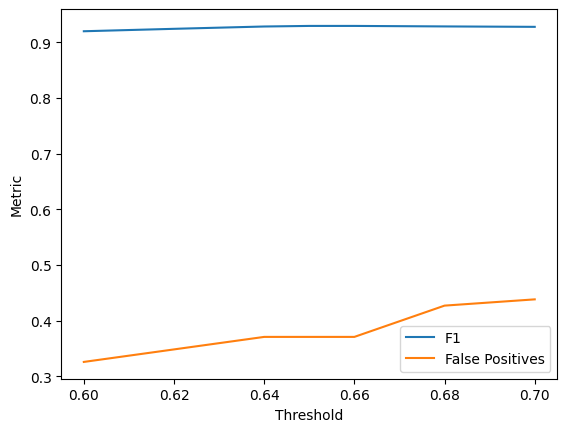

In [34]:
plt.plot(thresholds_to_test, perf_results['f1_score'], label='F1')
plt.plot(thresholds_to_test, fp_results['fpr'], label='False Positives')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# BERT + Relabeled + NLI Evaluation with Dual Optimization
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AutoTokenizer, AutoModelForSequenceClassification

# ===== Load both datasets =====
# Performance test dataset
df_performance = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels_perf = df_performance['true_class'].map({'non-suicide':0, 'suicide':1}).values

# False positive test dataset
df_fp = pd.read_csv('../dataset/false_positive_test_set_with_personality.csv')  
true_labels_fp = [0] * len(df_fp)  # All should be non-suicide

print(f"Performance dataset size: {len(df_performance)}")
print(f"FP test dataset size: {len(df_fp)}")

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "../saved_models/bert_relabeled"
bert_model = BertForSequenceClassification.from_pretrained(model_dir)
bert_tokenizer = BertTokenizer.from_pretrained(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device).eval()

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses for NLI filtering =====
negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.65):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(post, hypo, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  # [entail, neutral, contradict]
            entail_prob = probs[0].item()  # entailment probability
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    return max_neg_entail_prob >= threshold

# ===== Function to evaluate dataset with specific threshold =====
def evaluate_dataset(df, true_labels, threshold, dataset_name="Dataset"):
    final_predictions = []
    batch_size = 16
    
    for i in range(0, len(df), batch_size):
        batch_texts = df['cleaned_text'][i:i+batch_size].tolist()

        # BERT tokenization
        encodings = bert_tokenizer(
            batch_texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        # BERT  predictions
        with torch.no_grad():
            outputs = bert_model(
                input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Apply NLI negative filtering with current threshold
        for text, pred in zip(batch_texts, batch_preds):
            if pred == 1:  # initially predicted as suicide
                is_negative = nli_negative_filter(text, threshold=threshold)
                final_predictions.append(0 if is_negative else 1)
            else:
                final_predictions.append(pred)

        # Free GPU memory
        torch.cuda.empty_cache()
    
    # Calculate metrics
    cm = confusion_matrix(true_labels, final_predictions)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = precision_score(true_labels, final_predictions, zero_division=0)
    recall = recall_score(true_labels, final_predictions, zero_division=0)
    f1 = f1_score(true_labels, final_predictions, zero_division=0)
    accuracy = np.mean(np.array(final_predictions) == true_labels)
    
    return {
        'threshold': threshold,
        'dataset': dataset_name,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'fpr': fpr,
        'fp': fp,
        'tp': tp,
        'tn': tn,
        'fn': fn,
        'predictions': final_predictions
    }

# ===== Multi-objective threshold optimization =====
thresholds_to_test = [0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70]
results = []

print("Testing thresholds for dual optimization (performance + FP reduction)...")
for threshold in thresholds_to_test:
    print(f"Testing threshold: {threshold:.2f}")
    
    # Evaluate on performance dataset
    result_perf = evaluate_dataset(df_performance, true_labels_perf, threshold, "Performance")
    
    # Evaluate on FP dataset
    result_fp = evaluate_dataset(df_fp, true_labels_fp, threshold, "FP_Test")
    
    results.append(result_perf)
    results.append(result_fp)
    
    print(f"  Performance - F1: {result_perf['f1_score']:.4f}, FP: {result_perf['fp']}")
    print(f"  FP Test - FPR: {result_fp['fpr']:.4f}, FP: {result_fp['fp']}")

# ===== Find optimal threshold using multi-objective optimization =====
results_df = pd.DataFrame(results)

# Separate results by dataset
perf_results = results_df[results_df['dataset'] == 'Performance']
fp_results = results_df[results_df['dataset'] == 'FP_Test']

# Create combined scoring metric
combined_scores = []
for threshold in thresholds_to_test:
    perf_data = perf_results[perf_results['threshold'] == threshold].iloc[0]
    fp_data = fp_results[fp_results['threshold'] == threshold].iloc[0]
    
    # Weighted combination of F1 (performance) and 1-FPR (FP reduction)
    # Adjust weights based on your priorities (0.7:0.3 favors performance, 0.5:0.5 balanced)
    weight_performance = 0.8
    weight_fp = 0.2
    
    # Normalize F1 score (0-1)
    normalized_f1 = perf_data['f1_score']
    
    # Normalize FP reduction (1-FPR, higher is better)
    normalized_fp_reduction = 1 - fp_data['fpr']
    
    # Combined score
    combined_score = (weight_performance * normalized_f1) + (weight_fp * normalized_fp_reduction)
    
    combined_scores.append({
        'threshold': threshold,
        'combined_score': combined_score,
        'f1_score': perf_data['f1_score'],
        'fpr': fp_data['fpr'],
        'fp_count': fp_data['fp'],
        'performance_fp': perf_data['fp']
    })

combined_df = pd.DataFrame(combined_scores)

# Filter thresholds that maintain F1 >= 0.92
df_valid = combined_df[combined_df['f1_score'] >= 0.92]

# Select threshold with the highest combined score
best_idx = df_valid['combined_score'].idxmax()
best_threshold = df_valid.loc[best_idx, 'threshold']
best_f1 = df_valid.loc[best_idx, 'f1_score']
best_fp = df_valid.loc[best_idx, 'fp_count']

print(f"Selected threshold: {best_threshold}")
print(f"F1 Score: {best_f1}")
print(f"False Positives: {best_fp}")
print("\n" + "="*60)
print("MULTI-OBJECTIVE THRESHOLD OPTIMIZATION RESULTS")
print("="*60)
print(combined_df.round(4))
print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Combined score: {best_combined_score:.4f}")
print(f"Performance F1: {combined_df.loc[best_idx, 'f1_score']:.4f}")
print(f"FP Test FPR: {combined_df.loc[best_idx, 'fpr']:.4f}")
print(f"FP Count: {combined_df.loc[best_idx, 'fp_count']}")

# ===== Final evaluation with optimal threshold =====
print(f"\nFinal evaluation with optimal threshold: {best_threshold:.2f}")

# Performance dataset
final_perf = evaluate_dataset(df_performance, true_labels_perf, best_threshold, "Performance_Final")
print("\nPerformance Dataset Results:")
print(f"F1 Score: {final_perf['f1_score']:.4f}")
print(f"Precision: {final_perf['precision']:.4f}")
print(f"Recall: {final_perf['recall']:.4f}")
print(f"False Positives: {final_perf['fp']}")

# FP dataset
final_fp = evaluate_dataset(df_fp, true_labels_fp, best_threshold, "FP_Test_Final")
print("\nFP Test Dataset Results:")
print(f"False Positive Rate: {final_fp['fpr']:.4f}")
print(f"False Positives: {final_fp['fp']}")
print(f"True Negatives: {final_fp['tn']}")

# ===== Comparison with baseline (no NLI) =====
print("\n" + "="*40)
print("COMPARISON WITH BASELINE (NO NLI FILTERING)")
print("="*40)

# Baseline for performance dataset
baseline_perf = evaluate_dataset(df_performance, true_labels_perf, 0.0, "Baseline")
print(f"Performance Baseline F1: {baseline_perf['f1_score']:.4f} → With NLI: {final_perf['f1_score']:.4f}")
print(f"Performance Baseline FP: {baseline_perf['fp']} → With NLI: {final_perf['fp']}")

# Baseline for FP dataset (all should be 0 predictions)
baseline_fp_predictions = []
for i in range(0, len(df_fp), 16):
    batch_texts = df_fp['cleaned_text'][i:i+16].tolist()
    
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        logits = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        baseline_fp_predictions.extend(batch_preds.tolist())

baseline_fp_count = sum(baseline_fp_predictions)
print(f"FP Test Baseline FP: {baseline_fp_count} → With NLI: {final_fp['fp']}")
print(f"FP Reduction: {((baseline_fp_count - final_fp['fp']) / baseline_fp_count * 100):.1f}%")

import matplotlib.pyplot as plt
plt.plot(thresholds_to_test, perf_results['f1_score'], label='F1')
plt.plot(thresholds_to_test, fp_results['fpr'], label='False Positives')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.show()

Performance dataset size: 1000
FP test dataset size: 89
Testing thresholds for dual optimization (performance + FP reduction)...
Testing threshold: 0.60
  Performance - F1: 0.9113, FP: 40
  FP Test - FPR: 0.2584, FP: 23
Testing threshold: 0.61
  Performance - F1: 0.9135, FP: 40
  FP Test - FPR: 0.2697, FP: 24
Testing threshold: 0.62
  Performance - F1: 0.9168, FP: 40
  FP Test - FPR: 0.2697, FP: 24
Testing threshold: 0.63
  Performance - F1: 0.9189, FP: 40
  FP Test - FPR: 0.2697, FP: 24
Testing threshold: 0.64
  Performance - F1: 0.9211, FP: 40
  FP Test - FPR: 0.2809, FP: 25
Testing threshold: 0.65
  Performance - F1: 0.9222, FP: 40
  FP Test - FPR: 0.2809, FP: 25
Testing threshold: 0.66
  Performance - F1: 0.9222, FP: 40
  FP Test - FPR: 0.2809, FP: 25
Testing threshold: 0.67
  Performance - F1: 0.9212, FP: 41
  FP Test - FPR: 0.3034, FP: 27
Testing threshold: 0.68
  Performance - F1: 0.9212, FP: 41
  FP Test - FPR: 0.3258, FP: 29
Testing threshold: 0.69
  Performance - F1: 0.9194, 

TypeError: BertWithPersonality.forward() missing 1 required positional argument: 'personality_feats'

Performance dataset size: 1000
FP test dataset size: 89
Testing thresholds for dual optimization (performance + FP reduction)...
Testing threshold: 0.60
  Performance - F1: 0.9198, FP: 52
  FP Test - FPR: 0.3258, FP: 29
Testing threshold: 0.61
  Performance - F1: 0.9219, FP: 52
  FP Test - FPR: 0.3483, FP: 31
Testing threshold: 0.62
  Performance - F1: 0.9241, FP: 53
  FP Test - FPR: 0.3483, FP: 31
Testing threshold: 0.63
  Performance - F1: 0.9262, FP: 53
  FP Test - FPR: 0.3596, FP: 32
Testing threshold: 0.64
  Performance - F1: 0.9283, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.65
  Performance - F1: 0.9293, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.66
  Performance - F1: 0.9293, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.67
  Performance - F1: 0.9284, FP: 54
  FP Test - FPR: 0.3933, FP: 35
Testing threshold: 0.68
  Performance - F1: 0.9284, FP: 54
  FP Test - FPR: 0.4270, FP: 38
Testing threshold: 0.69
  Performance - F1: 0.9266, 

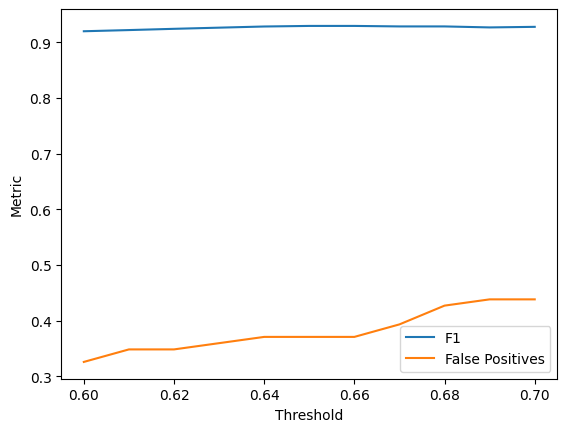

In [42]:
# BERT + Relabeled + Personality + NLI Evaluation with Dual Optimization
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AutoTokenizer, AutoModelForSequenceClassification

# ===== Load both datasets =====
# Performance test dataset
df_performance = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels_perf = df_performance['true_class'].map({'non-suicide':0, 'suicide':1}).values

# False positive test dataset
df_fp = pd.read_csv('../dataset/false_positive_test_set_with_personality.csv')  
true_labels_fp = [0] * len(df_fp)  # All should be non-suicide

print(f"Performance dataset size: {len(df_performance)}")
print(f"FP test dataset size: {len(df_fp)}")

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features for both datasets =====
personality_features_perf = df_performance[["extraversion", "agreeableness", "neuroticism"]].values
personality_features_perf = torch.tensor(personality_features_perf, dtype=torch.float32).to(device)

personality_features_fp = df_fp[["extraversion", "agreeableness", "neuroticism"]].values
personality_features_fp = torch.tensor(personality_features_fp, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = BertTokenizer.from_pretrained('../saved_models/bert_personality')

class BertWithPersonality(BertPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained BERT + Personality model =====
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
bert_personality_model = BertWithPersonality.from_pretrained('../saved_models/bert_personality', config=config)
bert_personality_model.to(device).eval()

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses for NLI filtering =====
negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.65):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(post, hypo, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  # [entail, neutral, contradict]
            entail_prob = probs[0].item()  # entailment probability
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    return max_neg_entail_prob >= threshold

# ===== Function to evaluate dataset with specific threshold =====
def evaluate_dataset(df, personality_features, true_labels, threshold, dataset_name="Dataset"):
    final_predictions = []
    batch_size = 16
    
    for i in range(0, len(df), batch_size):
        batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
        batch_personality = personality_features[i:i+batch_size]

        # BERT tokenization
        encodings = bert_tokenizer(
            batch_texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        # BERT + Personality predictions
        with torch.no_grad():
            logits = bert_personality_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                personality_feats=batch_personality
            )
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Apply NLI negative filtering with current threshold
        for text, pred in zip(batch_texts, batch_preds):
            if pred == 1:  # initially predicted as suicide
                is_negative = nli_negative_filter(text, threshold=threshold)
                final_predictions.append(0 if is_negative else 1)
            else:
                final_predictions.append(pred)

        # Free GPU memory
        torch.cuda.empty_cache()
    
    # Calculate metrics
    cm = confusion_matrix(true_labels, final_predictions)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = precision_score(true_labels, final_predictions, zero_division=0)
    recall = recall_score(true_labels, final_predictions, zero_division=0)
    f1 = f1_score(true_labels, final_predictions, zero_division=0)
    accuracy = np.mean(np.array(final_predictions) == true_labels)
    
    return {
        'threshold': threshold,
        'dataset': dataset_name,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'fpr': fpr,
        'fp': fp,
        'tp': tp,
        'tn': tn,
        'fn': fn,
        'predictions': final_predictions
    }

# ===== Multi-objective threshold optimization =====
thresholds_to_test = [0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70]
results = []

print("Testing thresholds for dual optimization (performance + FP reduction)...")
for threshold in thresholds_to_test:
    print(f"Testing threshold: {threshold:.2f}")
    
    # Evaluate on performance dataset
    result_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, threshold, "Performance")
    
    # Evaluate on FP dataset
    result_fp = evaluate_dataset(df_fp, personality_features_fp, true_labels_fp, threshold, "FP_Test")
    
    results.append(result_perf)
    results.append(result_fp)
    
    print(f"  Performance - F1: {result_perf['f1_score']:.4f}, FP: {result_perf['fp']}")
    print(f"  FP Test - FPR: {result_fp['fpr']:.4f}, FP: {result_fp['fp']}")

# ===== Find optimal threshold using multi-objective optimization =====
results_df = pd.DataFrame(results)

# Separate results by dataset
perf_results = results_df[results_df['dataset'] == 'Performance']
fp_results = results_df[results_df['dataset'] == 'FP_Test']

# Create combined scoring metric
combined_scores = []
for threshold in thresholds_to_test:
    perf_data = perf_results[perf_results['threshold'] == threshold].iloc[0]
    fp_data = fp_results[fp_results['threshold'] == threshold].iloc[0]
    
    # Weighted combination of F1 (performance) and 1-FPR (FP reduction)
    # Adjust weights based on your priorities (0.7:0.3 favors performance, 0.5:0.5 balanced)
    weight_performance = 0.8
    weight_fp = 0.2
    
    # Normalize F1 score (0-1)
    normalized_f1 = perf_data['f1_score']
    
    # Normalize FP reduction (1-FPR, higher is better)
    normalized_fp_reduction = 1 - fp_data['fpr']
    
    # Combined score
    combined_score = (weight_performance * normalized_f1) + (weight_fp * normalized_fp_reduction)
    
    combined_scores.append({
        'threshold': threshold,
        'combined_score': combined_score,
        'f1_score': perf_data['f1_score'],
        'fpr': fp_data['fpr'],
        'fp_count': fp_data['fp'],
        'performance_fp': perf_data['fp']
    })

combined_df = pd.DataFrame(combined_scores)

# Filter thresholds that maintain F1 >= 0.92
df_valid = combined_df[combined_df['f1_score'] >= 0.92]

# Select threshold with the highest combined score
best_idx = df_valid['combined_score'].idxmax()
best_threshold = df_valid.loc[best_idx, 'threshold']
best_f1 = df_valid.loc[best_idx, 'f1_score']
best_fp = df_valid.loc[best_idx, 'fp_count']

print(f"Selected threshold: {best_threshold}")
print(f"F1 Score: {best_f1}")
print(f"False Positives: {best_fp}")
print("\n" + "="*60)
print("MULTI-OBJECTIVE THRESHOLD OPTIMIZATION RESULTS")
print("="*60)
print(combined_df.round(4))
print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Combined score: {best_combined_score:.4f}")
print(f"Performance F1: {combined_df.loc[best_idx, 'f1_score']:.4f}")
print(f"FP Test FPR: {combined_df.loc[best_idx, 'fpr']:.4f}")
print(f"FP Count: {combined_df.loc[best_idx, 'fp_count']}")

# ===== Final evaluation with optimal threshold =====
print(f"\nFinal evaluation with optimal threshold: {best_threshold:.2f}")

# Performance dataset
final_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, best_threshold, "Performance_Final")
print("\nPerformance Dataset Results:")
print(f"F1 Score: {final_perf['f1_score']:.4f}")
print(f"Precision: {final_perf['precision']:.4f}")
print(f"Recall: {final_perf['recall']:.4f}")
print(f"False Positives: {final_perf['fp']}")

# FP dataset
final_fp = evaluate_dataset(df_fp, personality_features_fp, true_labels_fp, best_threshold, "FP_Test_Final")
print("\nFP Test Dataset Results:")
print(f"False Positive Rate: {final_fp['fpr']:.4f}")
print(f"False Positives: {final_fp['fp']}")
print(f"True Negatives: {final_fp['tn']}")

# ===== Comparison with baseline (no NLI) =====
print("\n" + "="*40)
print("COMPARISON WITH BASELINE (NO NLI FILTERING)")
print("="*40)

# Baseline for performance dataset
baseline_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, 0.0, "Baseline")
print(f"Performance Baseline F1: {baseline_perf['f1_score']:.4f} → With NLI: {final_perf['f1_score']:.4f}")
print(f"Performance Baseline FP: {baseline_perf['fp']} → With NLI: {final_perf['fp']}")

# Baseline for FP dataset (all should be 0 predictions)
baseline_fp_predictions = []
for i in range(0, len(df_fp), 16):
    batch_personality = personality_features_fp[i:i+16]
    batch_texts = df_fp['cleaned_text'][i:i+16].tolist()
    
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        baseline_fp_predictions.extend(batch_preds.tolist())

baseline_fp_count = sum(baseline_fp_predictions)
print(f"FP Test Baseline FP: {baseline_fp_count} → With NLI: {final_fp['fp']}")
print(f"FP Reduction: {((baseline_fp_count - final_fp['fp']) / baseline_fp_count * 100):.1f}%")

import matplotlib.pyplot as plt
plt.plot(thresholds_to_test, perf_results['f1_score'], label='F1')
plt.plot(thresholds_to_test, fp_results['fpr'], label='False Positives')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.show()